In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
from PIL import Image
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras import backend as K
import numpy as np


creating the generators

In [ ]:
batch_size = 16  #was 16
train_images = '/content/drive/MyDrive/bp/kaggle_crop_landmark/train'
test_images = '/content/drive/MyDrive/bp/kaggle_crop_landmark/test'

TrainDatagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        horizontal_flip = True


)

TestDatagen = ImageDataGenerator(
    preprocessing_function= preprocess_input

)

train_data = TrainDatagen.flow_from_directory(
    train_images,
    target_size = (224,224),
    batch_size =batch_size,
    class_mode = 'categorical'


)

test_data = TestDatagen.flow_from_directory(
    test_images,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3788 images belonging to 5 classes.
Found 955 images belonging to 5 classes.


In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# Open the VGG16 weight file
# f = h5py.File('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# # Select the layers for which you want to set weight.

# w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
# model.layers[1].set_weights = [w,b]

# w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
# model.layers[2].set_weights = [w,b]

# w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
# model.layers[4].set_weights = [w,b]

# w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
# model.layers[5].set_weights = [w,b]

# f.close()
model.summary()    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=10,min_delta= .05, monitor="val_accuracy")
chkpt = ModelCheckpoint(filepath='/content/drive/MyDrive/bp/smartcut_bestmodel.h5', save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
# Fit the model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model.fit(
    train_data,              
    steps_per_epoch = train_data.samples//batch_size,
    validation_split = 0.2,
    validation_data = test_data,
    validation_steps = test_data.samples//batch_size,
    epochs = 100,
    callbacks=[es,chkpt]
)

Epoch 1/100
236/236 [==============================] - 67s 279ms/step - loss: 1.6098 - accuracy: 0.1890 - val_loss: 1.6094 - val_accuracy: 0.1970
Epoch 2/100
236/236 [==============================] - 63s 267ms/step - loss: 1.5941 - accuracy: 0.2309 - val_loss: 1.6148 - val_accuracy: 0.1960
Epoch 3/100
236/236 [==============================] - 66s 279ms/step - loss: 1.4583 - accuracy: 0.3248 - val_loss: 1.5671 - val_accuracy: 0.2320
Epoch 4/100
236/236 [==============================] - 67s 284ms/step - loss: 1.3040 - accuracy: 0.4128 - val_loss: 1.2204 - val_accuracy: 0.4905
Epoch 5/100
236/236 [==============================] - 67s 283ms/step - loss: 1.2238 - accuracy: 0.4658 - val_loss: 1.2093 - val_accuracy: 0.4915
Epoch 6/100
236/236 [==============================] - 67s 282ms/step - loss: 1.1512 - accuracy: 0.4992 - val_loss: 1.0245 - val_accuracy: 0.5763
Epoch 7/100
236/236 [==============================] - 67s 282ms/step - loss: 1.1008 - accuracy: 0.5387 - val_loss: 0.9951 -

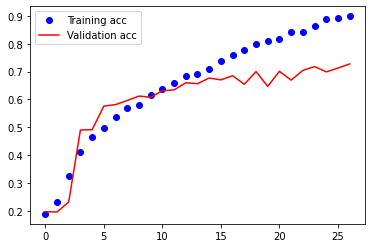

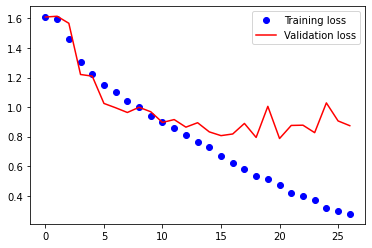

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt


epochs = range(len(acc))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend()


plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')

plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/bp/smartcut_vgg16.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/bp/smartcut_vgg16_weights.h5')

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/bp/smartcut_vgg16.h5')

In [ ]:
model.evaluate(test_data)

60/60 [==============================] - 6s 95ms/step - loss: 0.8692 - accuracy: 0.7288


[0.8691748380661011, 0.7287958264350891]

In [ ]:
pred = np.argmax(model.predict(test_data), axis = 1)

60/60 [==============================] - 6s 95ms/step


In [ ]:
import pandas as pd

classes = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

pred = pd.DataFrame(pred)

In [ ]:
for i in range(len(classes)):
  pred.replace(i, classes[i], inplace = True)

In [ ]:
pred.value_counts()

Square    218
Oblong    213
Round     183
Heart     177
Oval      164
dtype: int64